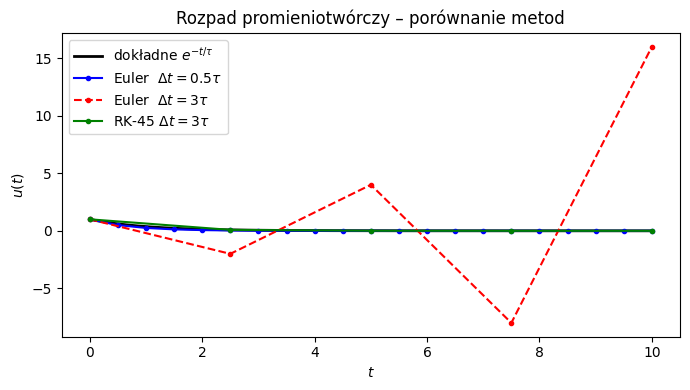

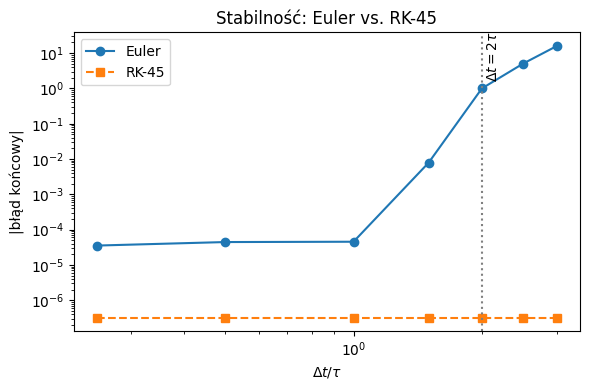

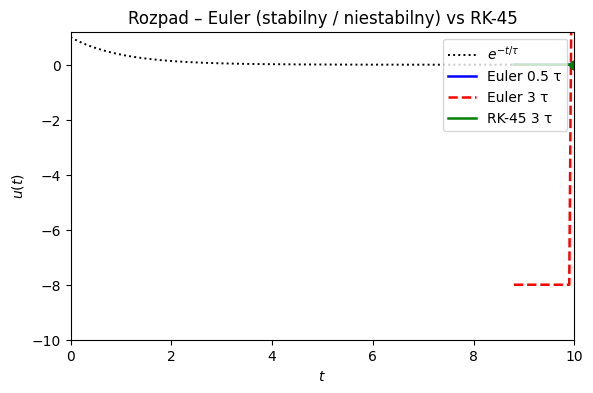

In [ ]:
# ============================================================
#  Rozpad promieniotwórczy  u' + u/τ = 0 ,  u(0)=1
#  Euler (własny)  vs.  RK-45 (biblioteka) • stabilność • animacja
# ============================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
mpl.rcParams["animation.html"] = "jshtml"
mpl.rcParams["animation.embed_limit"] = 4e6   # 4 MB

# ---------- 1.  dane problemu -------------------------------------------
τ = 1.0                               # stała czasowa
u_exact = lambda t: np.exp(-t/τ)      # rozwiązanie analityczne
f = lambda t, u: -u/τ                 # RHS w formie solve_ivp(t,u)

# ---------- 2.  Euler ----------------------------------------------------
def euler_int(t_span, u0, dt):
    t0, t1 = t_span
    N = int(np.ceil((t1-t0)/dt)) + 1
    t = np.linspace(t0, t1, N)
    u = np.empty(N); u[0] = u0
    for k in range(N-1):
        u[k+1] = u[k] + dt * (-u[k]/τ)
    return t, u

# ---------- 3.  dwie siatki czasu ---------------------------------------
t_span = (0, 10*τ)
dt_good = 0.5*τ             # stabilny Euler (Δt ≤ 2τ)
dt_bad  = 3.0*τ             # niestabilny Euler (Δt > 2τ)

t_ok,  u_ok  = euler_int(t_span, 1.0, dt_good)
t_bad, u_bad = euler_int(t_span, 1.0, dt_bad)

# RK-45 na tej samej grubszej siatce co niestabilny Euler (żeby porównać)
sol_rk = solve_ivp(f, t_span, [1.0], method='RK45', t_eval=t_bad,
                   rtol=1e-10, atol=1e-12)
u_rk = sol_rk.y[0]

# ---------- 4.  Wykres rozwiązania --------------------------------------
t_ref = np.linspace(*t_span, 400)
plt.figure(figsize=(7,4))
plt.plot(t_ref, u_exact(t_ref), 'k', lw=2, label=r"dokładne $e^{-t/\tau}$")
plt.plot(t_ok,  u_ok,  'b.-',  label=r"Euler  $\Delta t=0.5\tau$")
plt.plot(t_bad, u_bad, 'r.--', label=r"Euler  $\Delta t=3\tau$")
plt.plot(t_bad, u_rk,  'g.-',  label=r"RK-45 $\Delta t=3\tau$")
plt.xlabel("$t$"); plt.ylabel("$u(t)$")
plt.title("Rozpad promieniotwórczy – porównanie metod")
plt.legend(); plt.tight_layout(); plt.show()

# ---------- 5.  Stabilność: błąd końcowy vs Δt ---------------------------
dt_grid = np.array([0.25,0.5,1,1.5,2,2.5,3])*τ
err_eu, err_rk = [], []
for dt in dt_grid:
    err_eu.append(abs(euler_int(t_span,1,dt)[1][-1] - u_exact(t_span[1])))
    err_rk.append(abs(solve_ivp(f,t_span,[1],t_eval=[t_span[1]],
                                method='RK45').y[0,0] - u_exact(t_span[1])))
plt.figure(figsize=(6,4))
plt.loglog(dt_grid/τ, err_eu, "o-", label="Euler")
plt.loglog(dt_grid/τ, err_rk, "s--", label="RK-45")
plt.axvline(2, color='grey', ls=':')
plt.text(2.05, max(err_eu)*0.5, "$\\Delta t=2\\tau$", rotation=90, va='center')
plt.xlabel("$\\Delta t/\\tau$"); plt.ylabel("|błąd końcowy|")
plt.title("Stabilność: Euler vs. RK-45"); plt.legend(); plt.tight_layout(); plt.show()


# ---------- Animacja – stały oddalony kadr ---------------------------
dt_anim = 0.1*τ
t_anim  = np.arange(0, 10*τ+dt_anim, dt_anim)

from scipy.interpolate import interp1d
u_ok_a  = interp1d(t_ok,  u_ok,  kind='previous')(t_anim)
u_bad_a = interp1d(t_bad, u_bad, kind='previous')(t_anim)
u_rk_a  = interp1d(t_bad, u_rk,  kind='previous')(t_anim)

fig, ax = plt.subplots(figsize=(6.5,4))
ax.plot(t_ref, u_exact(t_ref), 'k:', lw=1.4, label=r"$e^{-t/\tau}$")
ax.set_xlim(0, 10*τ)
ax.set_ylim(-10, 1.2)                    # <<–– STAŁE, SZEROKIE GRANICE
ax.set_xlabel("$t$"); ax.set_ylabel("$u(t)$")
ax.set_title("Rozpad – Euler (stabilny / niestabilny) vs RK-45")

ln_ok,  = ax.plot([], [], 'b-',  lw=1.8, label="Euler 0.5 τ")
ln_bad, = ax.plot([], [], 'r--', lw=1.8, label="Euler 3 τ")
ln_rk,  = ax.plot([], [], 'g-',  lw=1.8, label="RK-45 3 τ")
pt_ok,  = ax.plot([], [], 'bo', ms=6)
pt_bad, = ax.plot([], [], 'ro', ms=6)
pt_rk,  = ax.plot([], [], 'go', ms=6)
ax.legend(loc="upper right")

trail = 12                                # ogon 12 punktów

def init():
    for ln,pt in [(ln_ok,pt_ok),(ln_bad,pt_bad),(ln_rk,pt_rk)]:
        ln.set_data([],[]); pt.set_data([],[])
    return ln_ok,ln_bad,ln_rk,pt_ok,pt_bad,pt_rk

def update(i):
    j = max(i-trail, 0)
    ln_ok .set_data(t_anim[j:i+1], u_ok_a [j:i+1])
    ln_bad.set_data(t_anim[j:i+1], u_bad_a[j:i+1])
    ln_rk .set_data(t_anim[j:i+1], u_rk_a [j:i+1])
    pt_ok .set_data([t_anim[i]], [u_ok_a [i]])
    pt_bad.set_data([t_anim[i]], [u_bad_a[i]])
    pt_rk .set_data([t_anim[i]], [u_rk_a [i]])
    return ln_ok,ln_bad,ln_rk,pt_ok,pt_bad,pt_rk

ani = FuncAnimation(fig, update, frames=len(t_anim),
                    init_func=init, interval=80, blit=True)
HTML(ani.to_jshtml())

## Wnioski z zadania 6 – rozpad promieniotwórczy

### 1. Zgodność numeryki z rozwiązaniem analitycznym
* Dla **Eulera** z krokiem $\Delta t = 0.5\tau$ oraz **RK-45** (z tym samym, większym krokiem $3\tau$) przebieg $u(t)$ praktycznie pokrywa się z dokładną funkcją wykładniczą $e^{-t/\tau}$.  
* Oznacza to, że oba algorytmy poprawnie odwzorowują zanik, o ile **spełniony jest warunek stabilności** (dla Eulera $\Delta t \le 2\tau$) lub metoda ma szerszy region stabilności (RK-45).

---

### 2. Granica stabilności jawnego Eulera
Z rekurencji

$$
u_{n+1}
    = u_n+\Delta t\!\left(-\frac{u_n}{\tau}\right)
    = u_n\!\left(1-\frac{\Delta t}{\tau}\right)
    = g\,u_n
$$

wynika współczynnik wzrostu $g$.   
Schemat jest stabilny tylko wtedy, gdy

$$
|g| = \Bigl|1-\frac{\Delta t}{\tau}\Bigr| \le 1
\;\;\Longrightarrow\;\;
\boxed{\Delta t \le 2\tau}\,.
$$

*Na animacji* czerwony przebieg z $\Delta t = 3\tau$ natychmiast oscyluje i rośnie (niestabilność); niebieski z $\Delta t = 0.5\tau$ maleje gładko.

---

### 3. Błąd globalny vs $\Delta t$
* Wykres log–log pokazuje nachylenie $\approx 1$ dla Eulera ⇒ schemat **I rzędu dokładności** ($|{\rm błąd}| \propto \Delta t$).  
* Dla RK-45 błąd pozostaje $\ll 10^{-8}$ w całym zakresie kroków, potwierdzając wyższy rząd (≥ 4) i szerszy region stabilności.

---

### 4. Rola animacji  
Stały, „oddalony” kadr $y\in[-10,\;1.2]$ pozwala jednocześnie obserwować:
* gładki zanik stabilnego Eulera (niebieski),  
* eksplozję niestabilnego Eulera (czerwony),  
* prawidłowy przebieg RK-45 (zielony).  

Ruchomy znacznik + krótki „ogon” (10 punktów) wizualizują tempo zmian.

---

### 5. Praktyczne rekomendacje  

| Metoda | Warunek stabilności | Co się dzieje po przekroczeniu granicy? | Dokładność / wydajność |
|--------|---------------------|-----------------------------------------|------------------------|
| **Euler** | $\Delta t \le 2\tau$ | Oscylacje i „wybuch” amplitudy | prosty; błąd $\sim\!\Delta t$ |
| **RK-45** | krok adaptacyjny ⇒ stabilny dla praktycznych $\Delta t$ | brak ostrej granicy; błąd $\sim\!\Delta t^{\,4}$ | większy krok przy tej samej dokładności |

**Wniosek końcowy:**  
Do krótkich, prostych symulacji wystarczy Euler z $\Delta t \lesssim 0.5\tau$;  
dla dłuższych przedziałów lub złożonych układów lepiej użyć metody wyższego rzędu (RK-45 lub schematu implicit).